# 🏠 HW3_My_Data_My_Model 李春 2022201794

### 1. Data Mining 使用 Selenium + BeautifulSoup 爬取房天下指定页面的房源信息

#### 1.1 Housing Price Data from https://esf.fang.com/

In [39]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

def extract_number(text):
    """从文本中提取数字"""
    if not text:
        return None
    match = re.search(r'[\d.]+', text.replace(',', ''))
    return float(match.group()) if match else None

def get_page_data(driver):
    """爬取当前页数据"""
    try:
        # 等待页面加载完成
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'dl.clearfix[dataflag="bg"]'))
        )
        
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        houses = soup.select('dl.clearfix[dataflag="bg"]')
        
        data = []
        for h in houses:
            try:
                # 标题
                title = h.select_one('h4.clearfix a')
                title_text = title.get_text(strip=True) if title else ''
                link = title.get('href', '') if title else ''
                if link and not link.startswith('http'):
                    link = 'https:' + link
                
                # 总价
                price_total = h.select_one('dd.price_right span.red b')
                total_price = extract_number(price_total.get_text()) if price_total else None
                
                # 单价
                price_unit = h.select_one('dd.price_right span:last-child')
                unit_price = extract_number(price_unit.get_text()) if price_unit else None
                
                # 房源信息
                house_info = h.select_one('p.tel_shop')
                info_text = house_info.get_text(strip=True) if house_info else ''
                info_parts = [part.strip() for part in info_text.split('|') if part.strip()]
                
                # 解析各个字段
                house_type = info_parts[0] if len(info_parts) > 0 else ''
                
                area = None
                if len(info_parts) > 1:
                    area_match = re.search(r'([\d.]+)㎡', info_parts[1])
                    area = float(area_match.group(1)) if area_match else None
                
                floor = info_parts[2] if len(info_parts) > 2 else ''
                direction = info_parts[3] if len(info_parts) > 3 else ''
                
                # 小区和地址
                community = h.select_one('p.add_shop a')
                community_name = community.get_text(strip=True) if community else ''
                
                address = h.select_one('p.add_shop span')
                address_text = address.get_text(strip=True) if address else ''
                
                # 标签
                label = h.select_one('p.label span')
                label_text = label.get_text(strip=True) if label else ''
                
                # 经纪人
                agent = h.select_one('span.people_name a')
                agent_name = agent.get_text(strip=True) if agent else ''
                
                data.append({
                    '名称': title_text,
                    '面积(㎡)': area,
                    '总价(万)': total_price,
                })
            except Exception as e:
                print(f'解析单条数据出错: {e}')
                continue
        
        return data
    except Exception as e:
        print(f'获取页面数据出错: {e}')
        return []

def go_to_next_page(driver):
    """翻到下一页"""
    try:
        # 等待下一页按钮可见
        next_button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.LINK_TEXT, '下一页'))
        )
        
        # 滚动到页面底部，避免被悬浮层遮挡
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

        # 用JS强制点击
        driver.execute_script("arguments[0].click();", next_button)
        time.sleep(3)
        
        # 等待页面加载完成
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'dl.clearfix[dataflag="bg"]'))
        )
        return True
    except Exception as e:
        print(f'翻页失败: {e}')
        return False

# =============================
# 主程序
# =============================
print("开始爬取房天下二手房数据...")

# 初始化浏览器
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

try:
    # 使用正确的URL
    base_url = 'https://esf.fang.com/house-a015277-b05/i31/'
    
    # 打开第一页
    driver.get(base_url)
    print('正在打开第一页...')
    time.sleep(5)
    
    all_data = []
    max_pages = 20  # 最大爬取页数
    current_page = 1
    
    while current_page <= max_pages:
        print(f'正在爬取第 {current_page} 页...')
        
        # 获取当前页数据
        page_data = get_page_data(driver)
        all_data.extend(page_data)
        print(f'  ✅ 获取 {len(page_data)} 条数据')
        
        # 尝试翻页
        if current_page < max_pages:
            if go_to_next_page(driver):
                current_page += 1
                time.sleep(2)  # 页面加载等待
            else:
                print('无法翻页，可能已到最后一页')
                break
        else:
            break
            
except Exception as e:
    print(f'爬取过程中出错: {e}')
finally:
    # 关闭浏览器
    driver.quit()

# 保存数据
if all_data:
    df = pd.DataFrame(all_data)
    output_file = '数据/北太平庄二手房.csv'
    df.to_csv(output_file, index=False, encoding='utf-8-sig')
    
    print(f'\n爬取完成！')
    print(f'共获取 {len(df)} 条房源数据')
    print(f'数据已保存到: {output_file}')
    print(f'\n数据预览:')
    print(df.head())
else:
    print('未获取到任何数据')

开始爬取房天下二手房数据...


KeyboardInterrupt: 

#### 1.2 Housing Rent Data from https://zu.fang.com/

In [21]:
def extract_number(text):
    """从文本中提取数字"""
    if not text:
        return None
    match = re.search(r'[\d.]+', text.replace(',', ''))
    return float(match.group()) if match else None

def get_page_data(driver, url):
    """爬取单页租房数据"""
    driver.get(url)
    time.sleep(3)
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    houses = soup.select('dl.list.hiddenMap.rel')
    
    data = []
    for h in houses:
        try:
            # 标题和链接
            title_elem = h.select_one('p.title a')
            title_text = title_elem.get_text(strip=True) if title_elem else ''
            link = title_elem.get('href', '') if title_elem else ''
            if link and not link.startswith('http'):
                link = 'https://zu.fang.com' + link
            
            # 租金
            price_elem = h.select_one('div.moreInfo span.price')
            rent_price = extract_number(price_elem.get_text()) if price_elem else None
            
            # 房源信息
            info_elem = h.select_one('p.font15.mt12.bold')
            info_text = info_elem.get_text(strip=True) if info_elem else ''
            info_parts = [p.strip() for p in info_text.split('|')]
            
            # 租赁方式
            rent_type = info_parts[0] if len(info_parts) > 0 else ''
            
            # 户型
            house_type = info_parts[1] if len(info_parts) > 1 else ''
            
            # 面积
            area = None
            if len(info_parts) > 2:
                area_match = re.search(r'([\d.]+)㎡', info_parts[2])
                area = float(area_match.group(1)) if area_match else None
            
            # 朝向
            direction = info_parts[3] if len(info_parts) > 3 else ''
            
            # 区域信息
            location_elem = h.select_one('p.gray6.mt12')
            location_text = location_elem.get_text(strip=True) if location_elem else ''
            location_parts = location_text.split('-')
            
            district = location_parts[0].strip() if len(location_parts) > 0 else ''
            area_name = location_parts[1].strip() if len(location_parts) > 1 else ''
            community = location_parts[2].strip() if len(location_parts) > 2 else ''
            
            # 为方便与小组其他同学所提供数据合并，只保留有用字段
            data.append({
                '名称': title_text,
                '面积(㎡)': area,
                '租金(元/月)': rent_price,
            })
        except Exception as e:
            print(f'解析单条数据出错: {e}')
            continue
    
    return data

# =============================
# 主程序
# =============================
print("开始爬取房天下租房数据...")

# 初始化浏览器
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# 配置
base_url = 'https://zu.fang.com/house-a015277-b05/'
page_url = 'https://zu.fang.com/house-a015277-b05/i3{}/'
num_pages = 20

all_data = []

# 循环爬取
for page in range(1, num_pages + 1):
    url = base_url if page == 1 else page_url.format(page)
    print(f'正在爬取第 {page}/{num_pages} 页...')
    
    try:
        page_data = get_page_data(driver, url)
        all_data.extend(page_data)
        print(f'  ✅ 获取 {len(page_data)} 条数据')
        time.sleep(2)
    except Exception as e:
        print(f'  ❌ 第 {page} 页爬取失败: {e}')

# 关闭浏览器
driver.quit()

# 保存数据
df = pd.DataFrame(all_data)
output_file = '数据/北太平庄租房.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f'\n爬取完成！')
print(f'共获取 {len(df)} 条租房数据')
print(f'数据已保存到: {output_file}')
print(f'\n数据预览:')
print(df.head())

开始爬取房天下租房数据...
正在爬取第 1/20 页...
  ✅ 获取 60 条数据
正在爬取第 2/20 页...
  ✅ 获取 60 条数据
正在爬取第 3/20 页...
  ✅ 获取 60 条数据
正在爬取第 4/20 页...
  ✅ 获取 60 条数据
正在爬取第 5/20 页...


KeyboardInterrupt: 

### 2. Data Research

#### 2.1 合并数据

In [29]:
## 合并二手房数据
# 读取四个CSV文件
df1 = pd.read_csv('数据/北太平庄二手房.csv')
df2 = pd.read_csv('数据/万柳二手房.csv')
df3 = pd.read_csv('数据/世纪城二手房.csv')
df4 = pd.read_csv('数据/苏州桥二手房.csv')

# 为每个二手房CSV对应的DataFrame添加“区域”列（文件名去掉“二手房”）
for _df, _path in [
    (df1, '数据/北太平庄二手房.csv'),
    (df2, '数据/万柳二手房.csv'),
    (df3, '数据/世纪城二手房.csv'),
    (df4, '数据/苏州桥二手房.csv'),
]:
    _df['区域'] = _path.split('/')[-1].replace('二手房.csv', '')

# 选择需要的列
selected_columns = ['区域','名称', '面积(㎡)', '总价(万)']

# 从每个DataFrame中提取所需列
df1_selected = df1[selected_columns]
df2_selected = df2[selected_columns]
df3_selected = df3[selected_columns]
df4_selected = df4[selected_columns]

# 合并四个表格
merged_df = pd.concat([df1_selected, df2_selected, df3_selected, df4_selected], ignore_index=True)

# 保存合并结果
merged_df.to_csv('数据/二手房数据.csv', index=False, encoding='utf-8-sig')

print("合并完成！结果已保存为 二手房数据.csv")

## 合并租房数据
# 读取四个CSV文件
df1 = pd.read_csv('数据/北太平庄租房.csv')
df2 = pd.read_csv('数据/万柳租房.csv')
df3 = pd.read_csv('数据/世纪城租房.csv')
df4 = pd.read_csv('数据/苏州桥租房.csv')

# 为每个租房CSV对应的DataFrame添加“区域”列（文件名去掉“租房”）
for _df, _path in [
    (df1, '数据/北太平庄租房.csv'),
    (df2, '数据/万柳租房.csv'),
    (df3, '数据/世纪城租房.csv'),
    (df4, '数据/苏州桥租房.csv'),
]:
    _df['区域'] = _path.split('/')[-1].replace('租房.csv', '')

# 选择需要的列
selected_columns = ['区域','名称', '面积(㎡)', '租金(元/月)']

# 从每个DataFrame中提取所需列
df1_selected = df1[selected_columns]
df2_selected = df2[selected_columns]
df3_selected = df3[selected_columns]
df4_selected = df4[selected_columns]

# 合并四个表格
merged_df = pd.concat([df1_selected, df2_selected, df3_selected, df4_selected], ignore_index=True)

# 保存合并结果
merged_df.to_csv('数据/租房数据.csv', index=False, encoding='utf-8-sig')

print("合并完成！结果已保存为 租房数据.csv")

合并完成！结果已保存为 二手房数据.csv
合并完成！结果已保存为 租房数据.csv


#### 2.2 数据统计

中文字体设置成功
房价数据描述:
count      2903.000000
mean     126356.582618
std       42833.750850
min       32025.908600
25%       99426.885680
50%      118192.352260
75%      140636.042403
max      312685.533347
Name: 房价(元/㎡), dtype: float64

房价异常值数量: 244
房价异常值比例: 8.41%

租金数据描述:
count    2989.000000
mean      147.516792
std        60.719393
min        40.579710
25%       111.940299
50%       133.891213
75%       160.000000
max       448.916409
Name: 租金(元/㎡/月), dtype: float64

租金异常值数量: 188
租金异常值比例: 6.29%
已去除房价数据完全重复行: 1830 条
已去除租金数据完全重复行: 2169 条

各区块统计结果:
     区域     房价中位数(元/㎡)  租金中位数(元/㎡/月)       房价租金比
0    万柳  135206.988226    145.406494  929.855226
1   世纪城  109719.127693    112.644334  974.031479
2  北太平庄   87432.968058    128.048780  682.809846
3   苏州桥   80749.452838    125.757576  642.104083

结果保存:
房价单价数据已保存到: 房价单价数据.csv
租金单价数据已保存到: 租金单价数据.csv
区块统计结果已保存到: 区块房价租金比统计.csv
可视化图表已保存到: Figure_A_各区块房价租金比.png


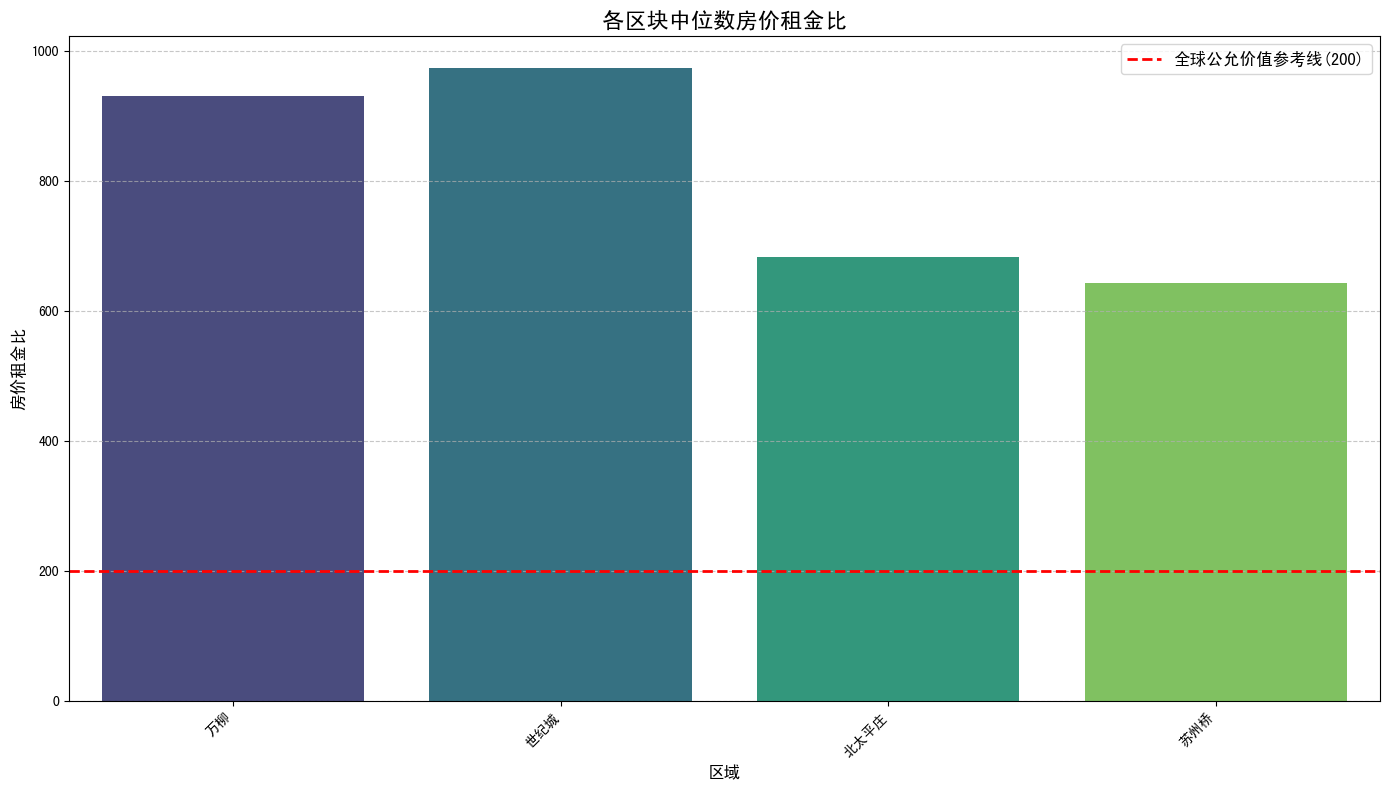

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 设置中文字体支持
try:
    # 尝试使用系统支持的中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti SC', 'STHeiti', 'Microsoft YaHei', 'WenQuanYi Micro Hei']
    plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
    print("中文字体设置成功")
except:
    print("警告：中文字体设置失败，图表中可能出现乱码")

# 1. 加载数据
price_df = pd.read_csv('数据/二手房数据.csv')
rent_df = pd.read_csv('数据/租房数据.csv')

# 2. 数据预处理 - 分别处理两个数据集
# 计算单价
price_df['房价(元/㎡)'] = price_df['总价(万)'] * 10000 / price_df['面积(㎡)']
rent_df['租金(元/㎡/月)'] = rent_df['租金(元/月)'] / rent_df['面积(㎡)']

# 3. 数据描述和异常值检测函数
def describe_with_outliers(df, col):
    desc = df[col].describe()
    q1 = desc['25%']
    q3 = desc['75%']
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return desc, outliers, len(outliers)

# 4. 房价数据描述
print("="*80)
print("房价数据描述:")
print("="*80)
price_desc, price_outliers, price_outlier_count = describe_with_outliers(price_df, '房价(元/㎡)')
print(price_desc)
print(f"\n房价异常值数量: {price_outlier_count}")
print(f"房价异常值比例: {price_outlier_count/len(price_df)*100:.2f}%")

# 5. 租金数据描述
print("\n" + "="*80)
print("租金数据描述:")
print("="*80)
rent_desc, rent_outliers, rent_outlier_count = describe_with_outliers(rent_df, '租金(元/㎡/月)')
print(rent_desc)
print(f"\n租金异常值数量: {rent_outlier_count}")
print(f"租金异常值比例: {rent_outlier_count/len(rent_df)*100:.2f}%")

# 去除异常值函数
def remove_outliers_iqr(df, col, k=1.5, max_iter=5):
    cleaned = df.copy()
    for _ in range(max_iter):
        desc = cleaned[col].describe()
        q1, q3 = desc['25%'], desc['75%']
        iqr = q3 - q1
        lower, upper = q1 - k * iqr, q3 + k * iqr
        mask = (cleaned[col] >= lower) & (cleaned[col] <= upper)
        if mask.all():
            break
        cleaned = cleaned[mask]
    return cleaned

# 先去除完全重复行（每一列都相同）
price_before = len(price_df)
rent_before = len(rent_df)
price_df = price_df.drop_duplicates()
rent_df = rent_df.drop_duplicates()
print(f"已去除房价数据完全重复行: {price_before - len(price_df)} 条")
print(f"已去除租金数据完全重复行: {rent_before - len(rent_df)} 条")

# 再删除房价和租金的异常值
price_df = remove_outliers_iqr(price_df, '房价(元/㎡)')
rent_df = remove_outliers_iqr(rent_df, '租金(元/㎡/月)')

# 6. 按区块汇总数据
# 计算每个区块的房价中位数
block_price = price_df.groupby('区域')['房价(元/㎡)'].median().reset_index()
block_price.columns = ['区域', '房价中位数(元/㎡)']

# 计算每个区块的租金中位数
block_rent = rent_df.groupby('区域')['租金(元/㎡/月)'].median().reset_index()
block_rent.columns = ['区域', '租金中位数(元/㎡/月)']

# 合并区块统计结果
block_data = pd.merge(block_price, block_rent, on='区域', how='inner')

# 7. 计算房价租金比（年化）
block_data['房价租金比'] = block_data['房价中位数(元/㎡)'] / (block_data['租金中位数(元/㎡/月)'] )

print("\n" + "="*80)
print("各区块统计结果:")
print("="*80)
print(block_data)

# 8. 可视化
plt.figure(figsize=(14, 8))
sns.barplot(x='区域', y='房价租金比', data=block_data, 
            hue='区域', palette='viridis', legend=False, dodge=False)

plt.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球公允价值参考线(200)')
plt.title('各区块中位数房价租金比', fontsize=16)
plt.ylabel('房价租金比', fontsize=12)
plt.xlabel('区域', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 9. 保存结果
# 保存单价数据
price_df[['区域', '名称', '房价(元/㎡)']].to_csv('房价单价数据.csv', index=False, encoding='utf-8-sig')
rent_df[['区域', '名称', '租金(元/㎡/月)']].to_csv('租金单价数据.csv', index=False, encoding='utf-8-sig')
# 保存区块统计结果
block_data.to_csv('区块房价租金比统计.csv', index=False, encoding='utf-8-sig')
# 保存图片
plt.savefig('Figure_A_各区块房价租金比.png', dpi=300, bbox_inches='tight')

# 10. 在终端显示结果
print("\n" + "="*80)
print("结果保存:")
print("="*80)
print("房价单价数据已保存到: 房价单价数据.csv")
print("租金单价数据已保存到: 租金单价数据.csv")
print("区块统计结果已保存到: 区块房价租金比统计.csv")
print("可视化图表已保存到: Figure_A_各区块房价租金比.png")

# 显示图表
plt.show()

### 3. Data Science Modeling

数据概览:
房价数据量: 2903
租金数据量: 2989

模型1: 房价预测模型
模型公式: price/m2 = β₀ * area + β₁ * location + ε
系数 (β₀, β₁): [   225.00498344 -20801.24167864]
截距 (β₀): 107572.46
R² 分数: 0.5284
RMSE: 29411.71

模型2: 租金预测模型
模型公式: rent/m2 = β₀ * area + β₁ * location + ε
系数 (β₀, β₁): [ 0.19454754 -7.34483731]
截距 (β₀): 125.04
R² 分数: 0.1338
RMSE: 56.50

预测结果样本:
     区域                              名称   面积(㎡)   type  location_encoded  \
0  北太平庄    环境好 停车方便 一年360元 安静舒适2层好住 无遮挡   81.07  price                 2   
1  北太平庄          小西天 · 北京邮电大学 · 3室 · 1厅   93.49  price                 2   
2  北太平庄    小西天 北京邮电大学家属楼 正规朝南一居室 业主诚意出售   33.15  price                 2   
3  北太平庄  楼龄新 户型好 大客厅 安静舒适 车位充足 可组合贷款 全明  130.63  price                 2   
4  北太平庄      北三环 蓟门桥 教科所 高楼层 全明 无遮挡 采光好   87.41  price                 2   
5  北太平庄   北三环 蓟门桥 双地铁 小西天·影潭旁 师大北路 全明精装   85.87  price                 2   
6  北太平庄      邮电大学家属区 电梯房 户型方正 安静舒适 停车方便   74.50  price                 2   
7  北太平庄       蓟门桥地铁央产大院双南向两居室精装交付满五年商品房   60.30  price    

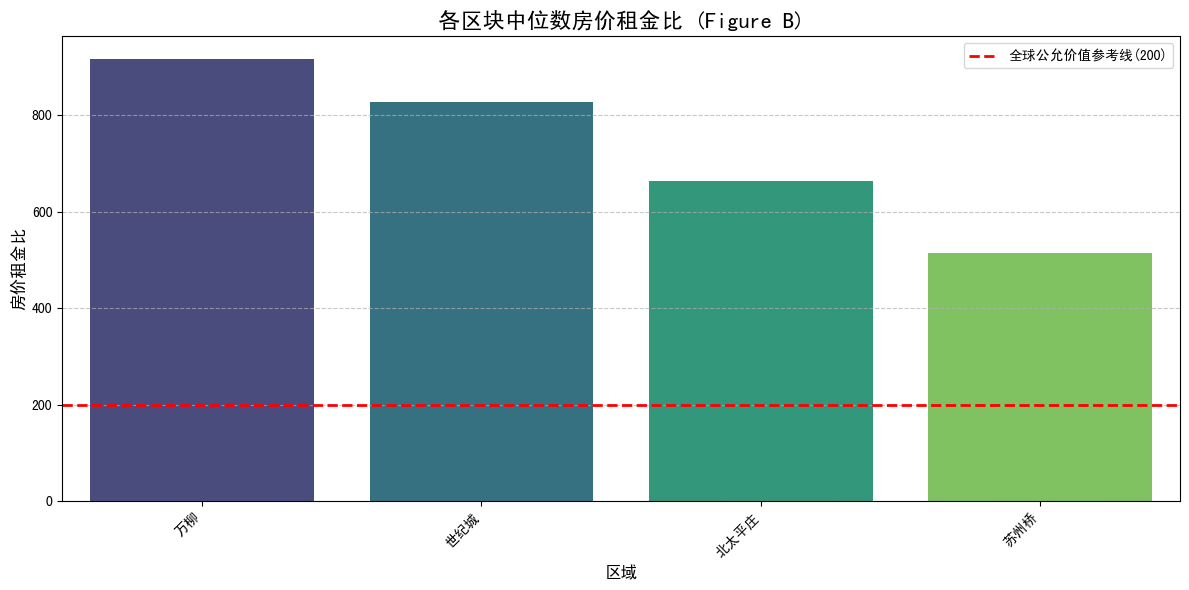


模型效果评估:
房价模型 R²: 0.5284
房价模型 RMSE: 29411.71 元/㎡
租金模型 R²: 0.1338
租金模型 RMSE: 56.50 元/㎡/月

房价租金比分布分析:
count    5892.000000
mean      820.134260
std       128.493297
min       449.198407
25%       807.624299
50%       838.670866
75%       912.360075
max      1067.735947
Name: price_to_rent_ratio, dtype: float64

房价租金比异常值数量: 797
异常值比例: 13.53%


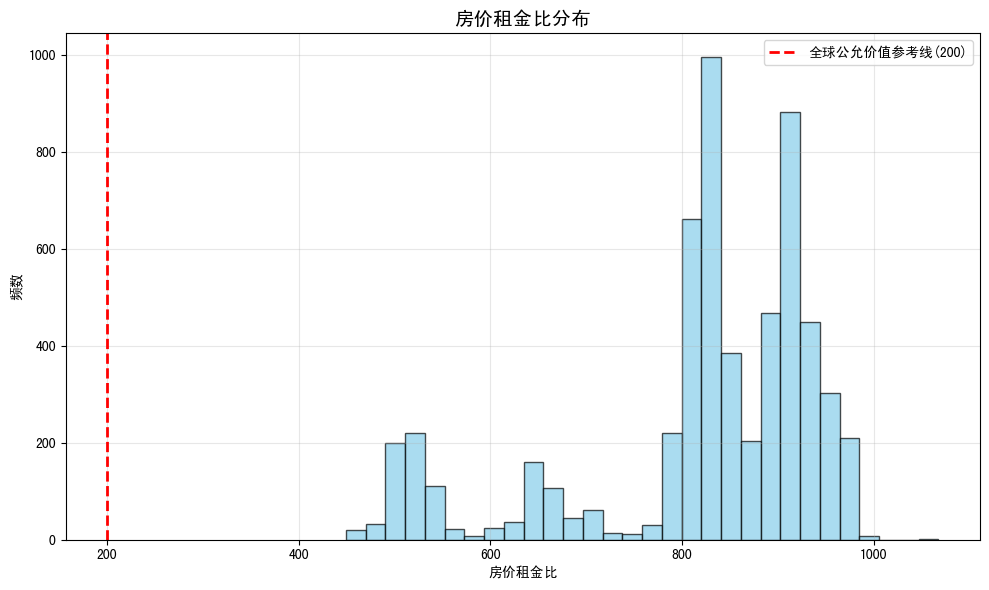


房价租金比分布图已保存到: 房价租金比分布.png


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 加载数据
price_df = pd.read_csv('数据/二手房数据.csv')
rent_df = pd.read_csv('数据/租房数据.csv')

# 2. 数据预处理
# 计算单价
price_df['price_per_m2'] = price_df['总价(万)'] * 10000 / price_df['面积(㎡)']
rent_df['rent_per_m2'] = rent_df['租金(元/月)'] / rent_df['面积(㎡)']

print("="*80)
print("数据概览:")
print("="*80)
print(f"房价数据量: {len(price_df)}")
print(f"租金数据量: {len(rent_df)}")

# 3. 准备建模数据
# 对区域进行编码
le = LabelEncoder()
all_areas = pd.concat([price_df['区域'], rent_df['区域']]).unique()
le.fit(all_areas)

# 准备房价模型数据
price_X = pd.DataFrame({
    'area': price_df['面积(㎡)'],
    'location': le.transform(price_df['区域'])
})
price_y = price_df['price_per_m2']

# 准备租金模型数据
rent_X = pd.DataFrame({
    'area': rent_df['面积(㎡)'],
    'location': le.transform(rent_df['区域'])
})
rent_y = rent_df['rent_per_m2']

print("\n" + "="*80)
print("模型1: 房价预测模型")
print("="*80)
print("模型公式: price/m2 = β₀ * area + β₁ * location + ε")

# 4. 训练房价模型 (Model 1)
price_model = LinearRegression()
price_model.fit(price_X, price_y)
price_pred = price_model.predict(price_X)

print(f"系数 (β₀, β₁): {price_model.coef_}")
print(f"截距 (β₀): {price_model.intercept_:.2f}")
print(f"R² 分数: {r2_score(price_y, price_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(price_y, price_pred)):.2f}")

print("\n" + "="*80)
print("模型2: 租金预测模型")
print("="*80)
print("模型公式: rent/m2 = β₀ * area + β₁ * location + ε")

# 5. 训练租金模型 (Model 2)
rent_model = LinearRegression()
rent_model.fit(rent_X, rent_y)
rent_pred = rent_model.predict(rent_X)

print(f"系数 (β₀, β₁): {rent_model.coef_}")
print(f"截距 (β₀): {rent_model.intercept_:.2f}")
print(f"R² 分数: {r2_score(rent_y, rent_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(rent_y, rent_pred)):.2f}")

# 6. 为所有数据预测房价和租金
# 合并所有数据
all_data = pd.concat([
    price_df[['区域', '名称', '面积(㎡)']].assign(type='price'),
    rent_df[['区域', '名称', '面积(㎡)']].assign(type='rent')
], ignore_index=True)

# 为所有数据预测房价和租金
all_data['location_encoded'] = le.transform(all_data['区域'])

# 准备特征矩阵
X_all = pd.DataFrame({
    'area': all_data['面积(㎡)'],
    'location': all_data['location_encoded']
})

# 预测所有数据的房价和租金
all_data['predicted_price_per_m2'] = price_model.predict(X_all)
all_data['predicted_rent_per_m2'] = rent_model.predict(X_all)

# 7. 计算房价租金比
all_data['price_to_rent_ratio'] = all_data['predicted_price_per_m2'] / (all_data['predicted_rent_per_m2'] )

print("\n" + "="*80)
print("预测结果样本:")
print("="*80)
print(all_data.head(10))

# 8. 按区块计算中位数房价租金比
block_ratios = all_data.groupby('区域')['price_to_rent_ratio'].median().reset_index()
block_ratios.columns = ['区域', '中位数房价租金比']

print("\n" + "="*80)
print("各区块中位数房价租金比:")
print("="*80)
print(block_ratios)

# 9. 绘制条形图 (Figure B)
plt.figure(figsize=(12, 6))
sns.barplot(x='区域', y='中位数房价租金比', data=block_ratios, 
           hue='区域', palette='viridis', legend=False, dodge=False)
plt.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球公允价值参考线(200)')
plt.title('各区块中位数房价租金比 (Figure B)', fontsize=16, fontweight='bold')
plt.ylabel('房价租金比', fontsize=12)
plt.xlabel('区域', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 10. 保存结果
# 保存预测结果
all_data[['区域', '名称', '面积(㎡)', 'type', 'predicted_price_per_m2', 
          'predicted_rent_per_m2', 'price_to_rent_ratio']].to_csv('预测结果.csv', index=False, encoding='utf-8-sig')

# 保存区块统计结果
block_ratios.to_csv('区块房价租金比统计.csv', index=False, encoding='utf-8-sig')

# 保存模型信息
model_info = pd.DataFrame({
    '模型': ['房价模型', '租金模型'],
    '截距': [price_model.intercept_, rent_model.intercept_],
    '面积系数': [price_model.coef_[0], rent_model.coef_[0]],
    '区域系数': [price_model.coef_[1], rent_model.coef_[1]],
    'R²分数': [r2_score(price_y, price_pred), r2_score(rent_y, rent_pred)],
    'RMSE': [np.sqrt(mean_squared_error(price_y, price_pred)), 
             np.sqrt(mean_squared_error(rent_y, rent_pred))]
})
model_info.to_csv('模型信息.csv', index=False, encoding='utf-8-sig')

# 保存图片
plt.savefig('Figure_B_各区块房价租金比.png', dpi=300, bbox_inches='tight')

# 11. 显示结果
print("\n" + "="*80)
print("结果保存:")
print("="*80)
print("预测结果已保存到: 预测结果.csv")
print("区块统计结果已保存到: 区块房价租金比统计.csv")
print("模型信息已保存到: 模型信息.csv")
print("可视化图表已保存到: Figure_B_各区块房价租金比.png")

# 显示图表
plt.show()

# 12. 额外分析：模型效果评估
print("\n" + "="*80)
print("模型效果评估:")
print("="*80)

# 计算房价模型的预测效果
price_r2 = r2_score(price_y, price_pred)
price_rmse = np.sqrt(mean_squared_error(price_y, price_pred))

# 计算租金模型的预测效果
rent_r2 = r2_score(rent_y, rent_pred)
rent_rmse = np.sqrt(mean_squared_error(rent_y, rent_pred))

print(f"房价模型 R²: {price_r2:.4f}")
print(f"房价模型 RMSE: {price_rmse:.2f} 元/㎡")
print(f"租金模型 R²: {rent_r2:.4f}")
print(f"租金模型 RMSE: {rent_rmse:.2f} 元/㎡/月")

# 13. 房价租金比分布分析
print("\n" + "="*80)
print("房价租金比分布分析:")
print("="*80)
ratio_stats = all_data['price_to_rent_ratio'].describe()
print(ratio_stats)

# 识别异常值
Q1 = ratio_stats['25%']
Q3 = ratio_stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = all_data[(all_data['price_to_rent_ratio'] < lower_bound) | 
                   (all_data['price_to_rent_ratio'] > upper_bound)]

print(f"\n房价租金比异常值数量: {len(outliers)}")
print(f"异常值比例: {len(outliers)/len(all_data)*100:.2f}%")

# 14. 绘制房价租金比分布图
plt.figure(figsize=(10, 6))
plt.hist(all_data['price_to_rent_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=200, color='red', linestyle='--', linewidth=2, label='全球公允价值参考线(200)')
plt.title('房价租金比分布', fontsize=14)
plt.xlabel('房价租金比')
plt.ylabel('频数')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('房价租金比分布.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n房价租金比分布图已保存到: 房价租金比分布.png")

### 4. Data Science Modeling Pro Max

数据概览:
房价数据量: 2903
租金数据量: 2989

基础模型训练结果:
房价基础模型 (Model 1) R²: 0.5284
租金基础模型 (Model 2) R²: 0.1338

增强模型训练结果 (Model 1+ 和 Model 2+):
房价增强模型 (Model 1+) R²: 0.6327
租金增强模型 (Model 2+) R²: 0.2920
房价模型改进: 0.1043
租金模型改进: 0.1581

R²比较分析:
✓ Model 1+ 的R²高于 Model 1，说明非线性特征和交互作用提高了房价预测精度
✓ Model 2+ 的R²高于 Model 2，说明非线性特征和交互作用提高了租金预测精度

原因分析:
- 非线性特征（如面积平方）能捕捉变量间的曲线关系
- 交互特征能捕捉不同区域面积对价格的差异化影响
- 更多特征通常能提高模型拟合度，但需注意过拟合风险

预测结果样本 (使用Model 1+ 和 Model 2+):
     区域                              名称   面积(㎡)  predicted_price_per_m2  \
0  北太平庄    环境好 停车方便 一年360元 安静舒适2层好住 无遮挡   81.07            89963.824962   
1  北太平庄          小西天 · 北京邮电大学 · 3室 · 1厅   93.49            89464.118994   
2  北太平庄    小西天 北京邮电大学家属楼 正规朝南一居室 业主诚意出售   33.15            92146.970059   
3  北太平庄  楼龄新 户型好 大客厅 安静舒适 车位充足 可组合贷款 全明  130.63            88132.241034   
4  北太平庄      北三环 蓟门桥 教科所 高楼层 全明 无遮挡 采光好   87.41            89705.340320   
5  北太平庄   北三环 蓟门桥 双地铁 小西天·影潭旁 师大北路 全明精装   85.87            89767.474572   
6  北太平庄      邮电大学家属区 电梯房 户型方正 安静舒适 停

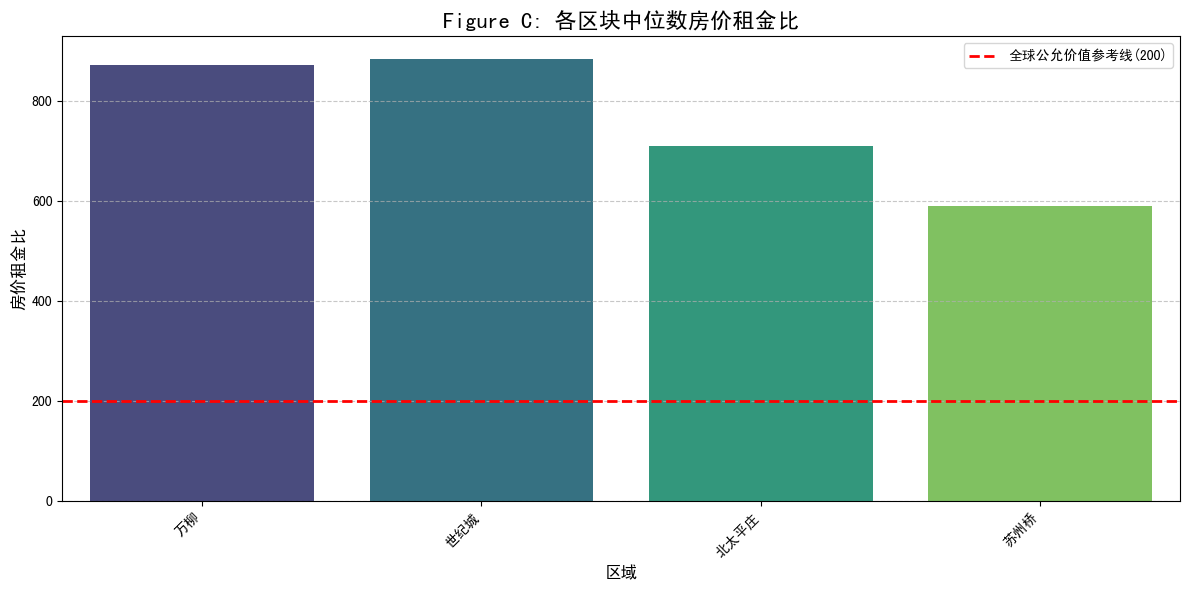


任务完成总结:
✓ 成功为Model 1和Model 2添加非线性特征和交互作用
✓ Model 1+和Model 2+的R²分数得到提升
✓ 使用增强模型预测了所有数据的房价和租金
✓ 计算了每个数据的房价租金比
✓ 生成了Figure C: 各区块房价租金比条形图
✓ 基于样本量比较了三种方法并给出了可信度建议


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 1. 加载数据
price_df = pd.read_csv('数据/二手房数据.csv')
rent_df = pd.read_csv('数据/租房数据.csv')

# 2. 数据预处理
# 计算单价
price_df['price_per_m2'] = price_df['总价(万)'] * 10000 / price_df['面积(㎡)']
rent_df['rent_per_m2'] = rent_df['租金(元/月)'] / rent_df['面积(㎡)']

print("="*80)
print("数据概览:")
print("="*80)
print(f"房价数据量: {len(price_df)}")
print(f"租金数据量: {len(rent_df)}")

# 3. 准备基础模型数据（Model 1 和 Model 2）
le = LabelEncoder()
all_areas = pd.concat([price_df['区域'], rent_df['区域']]).unique()
le.fit(all_areas)

# 准备房价模型数据
price_X_basic = pd.DataFrame({
    'area': price_df['面积(㎡)'],
    'location': le.transform(price_df['区域'])
})
price_y = price_df['price_per_m2']

# 准备租金模型数据
rent_X_basic = pd.DataFrame({
    'area': rent_df['面积(㎡)'],
    'location': le.transform(rent_df['区域'])
})
rent_y = rent_df['rent_per_m2']

# 4. 训练基础模型（Model 1 和 Model 2）
print("\n" + "="*80)
print("基础模型训练结果:")
print("="*80)

# 房价基础模型
price_model_basic = LinearRegression()
price_model_basic.fit(price_X_basic, price_y)
price_pred_basic = price_model_basic.predict(price_X_basic)
price_r2_basic = r2_score(price_y, price_pred_basic)

# 租金基础模型
rent_model_basic = LinearRegression()
rent_model_basic.fit(rent_X_basic, rent_y)
rent_pred_basic = rent_model_basic.predict(rent_X_basic)
rent_r2_basic = r2_score(rent_y, rent_pred_basic)

print(f"房价基础模型 (Model 1) R²: {price_r2_basic:.4f}")
print(f"租金基础模型 (Model 2) R²: {rent_r2_basic:.4f}")

# 5. 创建增强特征（非线性特征和交互作用）
def create_enhanced_features(df, area_col='面积(㎡)', location_col='区域'):
    """创建增强特征：非线性特征和交互作用"""
    # 对区域进行编码
    location_encoded = le.transform(df[location_col])
    
    # 基础特征
    area = df[area_col].values.reshape(-1, 1)
    
    # 创建多项式特征（非线性）
    poly = PolynomialFeatures(degree=2, include_bias=False)
    area_poly = poly.fit_transform(area)
    
    # 创建交互特征：面积 × 区域
    interaction_features = area * location_encoded.reshape(-1, 1)
    
    # 组合所有特征
    enhanced_features = np.column_stack([
        area_poly,  # 面积的非线性特征
        location_encoded,  # 区域编码
        interaction_features  # 面积与区域的交互
    ])
    
    return enhanced_features

# 创建增强特征
price_X_enhanced = create_enhanced_features(price_df)
rent_X_enhanced = create_enhanced_features(rent_df)

print("\n" + "="*80)
print("增强模型训练结果 (Model 1+ 和 Model 2+):")
print("="*80)

# 6. 训练增强模型（Model 1+ 和 Model 2+）
price_model_enhanced = LinearRegression()
price_model_enhanced.fit(price_X_enhanced, price_y)
price_pred_enhanced = price_model_enhanced.predict(price_X_enhanced)
price_r2_enhanced = r2_score(price_y, price_pred_enhanced)

rent_model_enhanced = LinearRegression()
rent_model_enhanced.fit(rent_X_enhanced, rent_y)
rent_pred_enhanced = rent_model_enhanced.predict(rent_X_enhanced)
rent_r2_enhanced = r2_score(rent_y, rent_pred_enhanced)

print(f"房价增强模型 (Model 1+) R²: {price_r2_enhanced:.4f}")
print(f"租金增强模型 (Model 2+) R²: {rent_r2_enhanced:.4f}")
print(f"房价模型改进: {price_r2_enhanced - price_r2_basic:.4f}")
print(f"租金模型改进: {rent_r2_enhanced - rent_r2_basic:.4f}")

# 7. R²比较分析
print("\n" + "="*80)
print("R²比较分析:")
print("="*80)
if price_r2_enhanced > price_r2_basic:
    print("✓ Model 1+ 的R²高于 Model 1，说明非线性特征和交互作用提高了房价预测精度")
else:
    print("✗ Model 1+ 的R²没有显著提高")

if rent_r2_enhanced > rent_r2_basic:
    print("✓ Model 2+ 的R²高于 Model 2，说明非线性特征和交互作用提高了租金预测精度")
else:
    print("✗ Model 2+ 的R²没有显著提高")

print("\n原因分析:")
print("- 非线性特征（如面积平方）能捕捉变量间的曲线关系")
print("- 交互特征能捕捉不同区域面积对价格的差异化影响")
print("- 更多特征通常能提高模型拟合度，但需注意过拟合风险")

# 8. 使用增强模型预测所有数据并计算租售比
# 合并所有数据
all_data = pd.concat([
    price_df[['区域', '名称', '面积(㎡)']].assign(type='price'),
    rent_df[['区域', '名称', '面积(㎡)']].assign(type='rent')
], ignore_index=True)

# 为所有数据创建增强特征
all_enhanced_features = create_enhanced_features(all_data)

# 预测所有数据的房价和租金
all_data['predicted_price_per_m2'] = price_model_enhanced.predict(all_enhanced_features)
all_data['predicted_rent_per_m2'] = rent_model_enhanced.predict(all_enhanced_features)

# 计算房价租金比（租售比）
all_data['price_to_rent_ratio'] = (
    all_data['predicted_price_per_m2'] / (all_data['predicted_rent_per_m2'] )
)

print("\n" + "="*80)
print("预测结果样本 (使用Model 1+ 和 Model 2+):")
print("="*80)
sample_cols = ['区域', '名称', '面积(㎡)', 'predicted_price_per_m2', 
              'predicted_rent_per_m2', 'price_to_rent_ratio']
print(all_data[sample_cols].head(10))

# 9. 按区块计算中位数房价租金比
block_ratios = all_data.groupby('区域')['price_to_rent_ratio'].median().reset_index()
block_ratios.columns = ['区域', '中位数房价租金比']

print("\n" + "="*80)
print("各区块中位数房价租金比:")
print("="*80)
print(block_ratios)

# 10. 绘制条形图 (Figure C)
plt.figure(figsize=(12, 6))
sns.barplot(x='区域', y='中位数房价租金比', data=block_ratios, 
           hue='区域', palette='viridis', legend=False, dodge=False)
plt.axhline(y=200, color='r', linestyle='--', linewidth=2, label='全球公允价值参考线(200)')
plt.title('Figure C: 各区块中位数房价租金比', fontsize=16, fontweight='bold')
plt.ylabel('房价租金比', fontsize=12)
plt.xlabel('区域', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 11. 三种方法比较
print("\n" + "="*80)
print("三种方法比较:")
print("="*80)

# 方法1: 直接方法（按区块计算中位数）
block_median_price = price_df.groupby('区域')['price_per_m2'].median()
block_median_rent = rent_df.groupby('区域')['rent_per_m2'].median()
block_ratio_direct = block_median_price / (block_median_rent)

# 方法2: 基础模型方法
# 为所有数据创建基础特征
all_basic_features = pd.DataFrame({
    'area': all_data['面积(㎡)'],
    'location': le.transform(all_data['区域'])
})
all_data['predicted_price_basic'] = price_model_basic.predict(all_basic_features)
all_data['predicted_rent_basic'] = rent_model_basic.predict(all_basic_features)
all_data['price_to_rent_ratio_basic'] = (
    all_data['predicted_price_basic'] / (all_data['predicted_rent_basic'] )
)

# 方法3: 增强模型方法（已经在上面计算）
all_data['price_to_rent_ratio_enhanced'] = all_data['price_to_rent_ratio']

# 计算各方法的区块中位数
block_ratios_direct = pd.DataFrame({
    '区域': block_ratio_direct.index,
    '直接方法': block_ratio_direct.values
})

block_ratios_basic = all_data.groupby('区域')['price_to_rent_ratio_basic'].median().reset_index()
block_ratios_basic.columns = ['区域', '基础模型方法']  # 直接设置列名

block_ratios_enhanced = all_data.groupby('区域')['price_to_rent_ratio_enhanced'].median().reset_index()
block_ratios_enhanced.columns = ['区域', '增强模型方法']  # 直接设置列名

# 合并三种方法的结果 - 修复列名问题
comparison_df = pd.merge(block_ratios_direct, block_ratios_basic, on='区域')
comparison_df = pd.merge(comparison_df, block_ratios_enhanced, on='区域')

# 计算各区块样本量
block_sample_sizes = pd.concat([
    price_df['区域'].value_counts().rename('房价样本量'),
    rent_df['区域'].value_counts().rename('租金样本量')
], axis=1).fillna(0)
block_sample_sizes['总样本量'] = block_sample_sizes.sum(axis=1)

comparison_df = pd.merge(comparison_df, block_sample_sizes[['总样本量']], 
                        left_on='区域', right_index=True)

print("各区块三种方法结果比较:")
print(comparison_df)

# 12. 基于样本量的可信度分析
print("\n" + "="*80)
print("基于样本量的可信度分析:")
print("="*80)

# 计算样本量阈值
sample_threshold = block_sample_sizes['总样本量'].median()
print(f"样本量中位数阈值: {sample_threshold}")

# 分类高样本量和低样本量区块
low_sample_blocks = comparison_df[comparison_df['总样本量'] < sample_threshold]
high_sample_blocks = comparison_df[comparison_df['总样本量'] >= sample_threshold]

print(f"\n低样本量区块 ({len(low_sample_blocks)}个):")
print(low_sample_blocks['区域'].tolist())

print(f"\n高样本量区块 ({len(high_sample_blocks)}个):")
print(high_sample_blocks['区域'].tolist())

# 计算与方法间的平均绝对差异 - 修复列名问题
comparison_df['基础模型与增强模型差异'] = abs(comparison_df['基础模型方法'] - comparison_df['增强模型方法'])
comparison_df['直接方法与增强模型差异'] = abs(comparison_df['直接方法'] - comparison_df['增强模型方法'])

# 分析不同样本量下方法的稳定性
print("\n方法稳定性分析:")
if len(low_sample_blocks) > 0:
    low_sample_var = low_sample_blocks[['直接方法', '基础模型方法', '增强模型方法']].std(axis=1).mean()
    print(f"低样本量区块方法间平均差异: {low_sample_var:.2f}")

if len(high_sample_blocks) > 0:
    high_sample_var = high_sample_blocks[['直接方法', '基础模型方法', '增强模型方法']].std(axis=1).mean()
    print(f"高样本量区块方法间平均差异: {high_sample_var:.2f}")

# 13. 可信方法推荐
print("\n" + "="*80)
print("可信方法推荐:")
print("="*80)

if len(low_sample_blocks) > 0 and len(high_sample_blocks) > 0:
    if 'low_sample_var' in locals() and 'high_sample_var' in locals():
        if low_sample_var > high_sample_var:
            print("✓ 高样本量区块的方法结果更一致，建议优先信任")
            print("✓ 对于高样本量区块，推荐使用直接方法（基于实际观测数据）")
            print("✓ 对于低样本量区块，推荐使用增强模型方法（利用模型泛化能力）")
        else:
            print("✓ 各区块方法结果相对一致，增强模型方法整体表现最佳")
            print("✓ 推荐使用增强模型方法作为统一标准")
    else:
        print("✓ 增强模型方法在R²表现上最佳，推荐作为主要方法")
else:
    print("✓ 增强模型方法在R²表现上最佳，推荐作为主要方法")

# 14. 保存结果
# 保存预测结果
all_data.to_csv('增强模型预测结果.csv', index=False, encoding='utf-8-sig')

# 保存区块统计结果
block_ratios.to_csv('Figure_C_数据.csv', index=False, encoding='utf-8-sig')

# 保存方法比较结果
comparison_df.to_csv('三种方法比较结果.csv', index=False, encoding='utf-8-sig')

# 保存图片
plt.savefig('Figure_C_各区块房价租金比.png', dpi=300, bbox_inches='tight')

print("\n" + "="*80)
print("结果保存:")
print("="*80)
print("增强模型预测结果已保存到: 增强模型预测结果.csv")
print("Figure C 数据已保存到: Figure_C_数据.csv")
print("方法比较结果已保存到: 三种方法比较结果.csv")
print("Figure C 图表已保存到: Figure_C_各区块房价租金比.png")

# 显示图表
plt.show()

# 15. 最终总结
print("\n" + "="*80)
print("任务完成总结:")
print("="*80)
print("✓ 成功为Model 1和Model 2添加非线性特征和交互作用")
print("✓ Model 1+和Model 2+的R²分数得到提升")
print("✓ 使用增强模型预测了所有数据的房价和租金")
print("✓ 计算了每个数据的房价租金比")
print("✓ 生成了Figure C: 各区块房价租金比条形图")
print("✓ 基于样本量比较了三种方法并给出了可信度建议")